# 決定木

In [1]:
# 定型ライブラリ読み込み
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import scipy
from scipy import stats
from numpy.random import randn
import copy

C:\Users\YusukeSato\Anaconda3\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


## 単純な決定木

In [2]:
# 損失関数を定義
##　二乗誤差
def sq_loss(y):
    if len(y) == 0:
        return 0
    else:
        y_bar = np.mean(y)
        return np.linalg.norm(y-y_bar)**2  # L2ノルムを計算し二乗している

In [3]:
test_x = [[1,2,3],[4,5,6],[7,8,9]]
print(test_x)
print(test_x.pop())

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]
[7, 8, 9]


In [4]:
# 枝の分割
# 総当たり計算を実施
    # 1. 各変数それぞれに対して
    # 2. あるデータiを選択したときに
    # 3. データiを閾値としてそれより小さいものをleft,以上をrightに格納
    # 4. 分割したときの損失関数を算出
    # 5. 損失関数が過去最少であった場合、閾値とデータ集合を更新
def branch(x, y, S, rf = 0):
    # x:入力データ
    # y:ターゲットデータ
    # S:変数jにおける全データを格納
    # rf:ランダムフォレストの実施の有無？
    if rf == 0:
        m = x.shape[1]   # mに変数の個数を格納
    if x.shape[0] == 0:  # データがないとき？
        return([0,0,0,0,0,0,0])
    
    #print(S)
    
    best_score = np.inf  # スコアをinfに設定し、最小値を探す
    
    for j in range(x.shape[1]):     # 変数の数だけループ
        for i in S:                 # 後で出てくるコードでSにpoppedを格納している popはオプションなしで指定した配列の最後の要素を取り出す
            left = []; right = []   # 枝の左右を初期化、left,rightはそれぞれの枝に入ったindexのリストである
            for k in S:
                if x[k,j] < x[i,j]:  # 枝の左右への振り分け j番目の変数におけるi番目のデータを閾値としたときの振り分けを実施
                    left.append(k)   # 左に入ったデータのindexのリストに新たにindexを追加
                else:
                    right.append(k)  # 右に入ったデータのindexのリストに新たにindexを追加
            left_score = f(y[left])           # 左側の損失関数を計算
            right_score = f(y[right])         # 右側の損失関数を計算
            score = left_score + right_score  # 合計値をスコアとする
            
            if score < best_score:                                      # スコアが過去のものより良い場合
                best_score = score                                      # スコアの最小値を更新
                i_1 = i; j_1 = j                                        # スコアが前回よりも小さい場合の閾値iと変数jのindexを格納
                left_1 = left; right_1 = right                          # 分割されたデータ集合left,rightのindexを格納
                left_score_1 = left_score; right_score_1 = right_score  # left,rightそれぞれの現時点での最小値を格納
                
    return [i_1, j_1, left_1, right_1, best_score, left_score_1, right_score_1]  # 返却

In [5]:
# データスタック
    # データ格納用にクラスを利用
class Stack:
    def __init__(self, parent, set, score):
        self.parent = parent   # 親ノードの番号
        self.set = set         # データのindexリスト
        self.score = score     # 損失関数

In [6]:
# ノード
    # データ格納用にクラスを利用
class Node:
    def __init__(self, parent, j, th, set):
        # parent:親ノードの番号
        # j:自身のノード番号
        # th:分岐の際の閾値
        # set:ノード内のデータ集合のindexリスト
        self.parent = parent
        self.j = j
        self.th = th
        self.set = set

In [27]:
# 枝を伸ばす
def dt(x, y, alpha = 0, n_min = 1, rf = 0):
    # x:入力データ
    # y:ターゲットデータ
    # alpha:後で利用
    # n_min:各ノードにおけるデータ集合の最小値
    # rf:ランダムフォレストの実施の有無？
    if rf == 0:
        m = x.shape[1]
    
    stack = [Stack(0, list(range(x.shape[0])), f(y))]   # stackを初期化
    node = []   # nodeを初期化
    k = -1      # kを初期化
    
    # stackに何かしらデータが残っている間のループ
    while len(stack) > 0:
        popped = stack.pop()   # stackの最後のデータを取り出してpoppedに格納
        #print(popped.parent, popped.score, popped.set)

        k = k + 1
        i, j, left, right, score, left_score, right_score = branch(x, y, popped.set, rf)  # 枝の分割を計算 Sにはpopped.setを入れる
        if popped.score - score < alpha or len(popped.set) < n_min or len(left) == 0 or len(right) == 0:
            # 以下の条件を満たすとき、枝をそこで止める
            ## 1. 一回前とのスコアの差分が閾値alphaより小さい
            ## 2. ノードのデータ集合数がn_minより小さい
            ## 3. 左の枝が空集合
            ## 4. 右の枝が空集合
            node.append(Node(popped.parent, -1, 0, popped.set))
        else:
            node.append(Node(popped.parent, j, x[i,j], popped.set))
            stack.append(Stack(k, right, right_score))
            stack.append(Stack(k, left, left_score))
    ### 枝を伸ばす処理はここまで
    
    # ノードの分岐構造をデータにする
    for h in range(k, -1, -1):
        # kは枝の数
        # 各ノードにleft, rightを設定する、そのための初期化
        node[h].left = 0
        node[h].right = 0

    for h in range(k, 0, -1):  # kから降順で最後の値の一つ手前まで
        pa = node[h].parent       # node[h]の親ノードをpaに格納
        #print(h, pa)
        if node[pa].right == 0:   # node[h]の親ノードの右側にまだ値が格納されていない場合
            node[pa].right = h   # node[h]をその親ノードのrightに格納
        else:                     # そうでない場合
            node[pa].left = h    # node[h]をその親ノードのleftに格納
        #print(h, pa, node[pa].right, node[pa].left)
    
    # 
    if f == sq_loss:      # 損失関数を二乗誤差にした場合の処理
        g = np.mean       # 平均値を引数に与える関数とする
    else:
        g = mode_max      # 中央値を引数に与える関数とする
    for h in range(k+1):
        if node[h].j == -1:    # ノードが枝分かれしていない場合
            node[h].center = g(y[node[h].set])    # そのノードの集合におけるターゲットの平均もしくは最頻値をそのノードのcenterとする
        else:
            node[h].center = 0                    # ノードが枝分かれしている場合はcenterを決めずとする
            
    return node

In [28]:
for i in range(10, 0, -1):
    print(i)

10
9
8
7
6
5
4
3
2
1


## 使用するデータの読み込み

In [29]:
from sklearn.datasets import load_boston
import pandas as pd

In [30]:
boston = load_boston()
X = boston.data
y = boston.target
f = sq_loss
node = dt(X, y, n_min = 50)

In [31]:
from igraph import *

In [32]:
r = len(node)
edge = []
for h in range(1, r):
    edge.append([node[h].parent, h])
TAB = []
for h in range(r):
    if not node[h].j == 0:
        TAB.append([h, node[h].j, node[h].th])
TAB

[[0, 5, 6.943],
 [1, 12, 14.43],
 [2, 7, 1.413],
 [3, -1, 0],
 [4, 5, 6.546],
 [5, 12, 7.6],
 [6, -1, 0],
 [7, 9, 223.0],
 [8, -1, 0],
 [9, 5, 6.083],
 [10, 6, 69.5],
 [11, 7, 4.4986],
 [12, -1, 0],
 [13, -1, 0],
 [14, -1, 0],
 [15, 12, 10.15],
 [16, -1, 0],
 [17, -1, 0],
 [18, 9, 273.0],
 [19, -1, 0],
 [20, -1, 0],
 [22, 4, 0.538],
 [23, -1, 0],
 [24, 12, 19.01],
 [25, 6, 85.7],
 [26, -1, 0],
 [27, -1, 0],
 [28, -1, 0],
 [29, 4, 0.614],
 [30, -1, 0],
 [31, 12, 19.77],
 [32, -1, 0],
 [33, -1, 0],
 [34, 5, 7.454],
 [35, -1, 0],
 [36, -1, 0]]

In [33]:
def draw_graph(node):
    r = len(node)
    col = []
    for h in range(r):
        col.append(node[h].j)
    colorlist = ['#ffffff','#fff8ff','#fcf9ce','#d6fada','#d7ffff','#d9f2f8','#fac8be','#ffebff','#ffffe0','#fdf5e6','#fac8be','#f8ecd5','#ee82ee']
    color = [colorlist[col[i]] for i in range(r)]
    edge = []
    for h in range(1,r):
        edge.append([node[h].parent,h])
        g = Graph(edges = edge, directed = True)
        layout = g.layout_reingold_tilford(root = [0])
    out = plot(g,
               vertex_size = 15,
               layout = layout,
               bbox = (300, 300),
               vertex_label = list(range(r)),
               vertex_color = color)
    return out

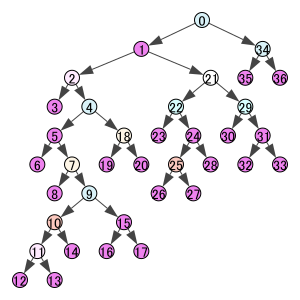

In [34]:
draw_graph(node)

In [35]:
for i in range(len(node)):
    print(node[i].right, node[i].left)

34 1
21 2
4 3
0 0
18 5
7 6
0 0
9 8
0 0
15 10
14 11
13 12
0 0
0 0
0 0
17 16
0 0
0 0
20 19
0 0
0 0
29 22
24 23
0 0
28 25
27 26
0 0
0 0
0 0
31 30
0 0
33 32
0 0
0 0
36 35
0 0
0 0


In [15]:
pd.DataFrame(boston.data, columns=boston.feature_names)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


## Cross-Validationを実施
- alphaとn_minの最適値を探索する

In [55]:
# 計算済みのモデルを使って新しいデータに対する予測値を計算
def value(u, node):
    # u:入力データ
    # node:計算済みのモデル
    r = 0    # 初期化
    
    #print(u)
    
    # 端点に達するまでループ
    while node[r].j != -1:
        #print(r)
        #print(node[r].left, node[r].right)
        if u[node[r].j] < node[r].th:   # 入力値が閾値よりも小さい場合、左のノードへ
            #print(node[r].left)
            #print(u[node[r].j], node[r].th)
            r = node[r].left
        else:                           # 入力値が閾値以上の場合、右のノードへ
            #print(node[r].right)
            r = node[r].right
    return node[r].center               # 端点に達した時、端点が格納しているcenterの値を返す

In [56]:
boston = load_boston()
n = 100
X = boston.data[range(n),:]
y = boston.target[range(n)]
f = sq_loss
alpha_seq = np.arange(0, 1.5, 0.1)
s = np.int(n/10)
out = []

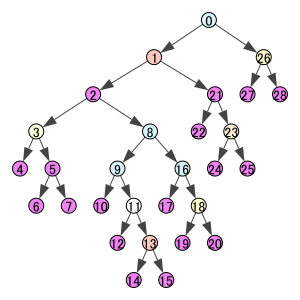

In [57]:
# check
h = 0
alpha = alpha_seq[0]
test = list(range(h*s, h*s+s))          # test用のindexリストを作成
train = list(set(range(n))-set(test))   # training用に、全indexリストからtest用のリストを除く
node = dt(X[train, :], y[train], n_min=10, alpha = alpha)  # 計算
draw_graph(node)

In [58]:
print(len(node))
for i in range(len(node)):
    print(node[i].j, node[i].parent, node[i].right, node[i].left)

29
5 0 26 1
6 0 21 2
12 1 8 3
8 2 5 4
-1 3 0 0
12 3 7 6
-1 5 0 0
-1 5 0 0
5 2 16 9
5 8 11 10
-1 9 0 0
0 9 13 12
-1 11 0 0
6 11 15 14
-1 13 0 0
-1 13 0 0
5 8 18 17
-1 16 0 0
2 16 20 19
-1 18 0 0
-1 18 0 0
12 1 23 22
-1 21 0 0
11 21 25 24
-1 23 0 0
-1 23 0 0
2 0 28 27
-1 26 0 0
-1 26 0 0


In [59]:
out = []   # outを空配列に初期化

for alpha in alpha_seq:
    SS = 0
    #print(alpha)
    for h in range(10):
        test = list(range(h*s, h*s+s))          # test用のindexリストを作成
        train = list(set(range(n))-set(test))   # training用に、全indexリストからtest用のリストを除く
        node = dt(X[train, :], y[train], alpha = alpha)  # 計算
        
        for t in test:
            #print(SS)
            SS = SS + (y[t] - value(X[t, :], node)) ** 2   # テストデータの各々について予測値を計算し、予測値との差の二乗をSSに足し上げる
            #print(SS)
    print(SS/n)
    out.append(SS/n)

11.2123
11.169741666666662
11.138088888888886
11.073173611111109
10.98831805555555
10.918474305555554
10.923048228458047
10.894865589569157
10.970726006235825
11.051589873456788
11.008887095679011
10.790952453955654
10.788552453955653
10.975752453955657
10.972330231733434


In [60]:
print(alpha_seq, len(alpha_seq))
print(out, len(out))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4] 15
[11.2123, 11.169741666666662, 11.138088888888886, 11.073173611111109, 10.98831805555555, 10.918474305555554, 10.923048228458047, 10.894865589569157, 10.970726006235825, 11.051589873456788, 11.008887095679011, 10.790952453955654, 10.788552453955653, 10.975752453955657, 10.972330231733434] 15


Text(0.5, 1.0, 'CVで最適なalpha(N=100)')

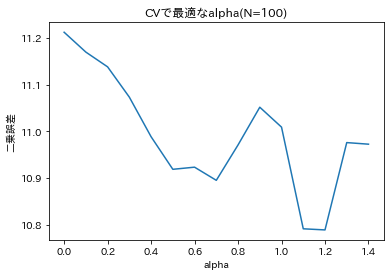

In [61]:
plt.plot(alpha_seq, out)
plt.xlabel('alpha')
plt.ylabel('二乗誤差')
plt.title('CVで最適なalpha(N=100)')

In [62]:
# n_minに関するcross-validation
boston = load_boston()
n = 100
X = boston.data[range(n),:]
y = boston.target[range(n)]
n_min_seq = np.arange(1,13,1)
s = np.int(n/10)
out = []

In [63]:
for n_min in n_min_seq:
    SS = 0
    for h in range(10):
        
        test = list(range(h*s, h*s+s))
        train = list(set(range(n)) - set(test))
        node = dt(X[train, :], y[train],alpha = 0, n_min = n_min)

        for t in test:
            SS = SS + (y[t] - value(X[t, :], node)) ** 2
    print(SS/n)
    out.append(SS/n)  

11.2123
11.2123
11.160350000000001
10.779608333333336
10.974831944444444
10.776290444444447
10.778481666666671
10.686344513038552
10.585849200538545
11.914784839238472
12.298008067255603
12.478392363347837


Text(0.5, 1.0, 'CVで最適なn_min(N=100)')

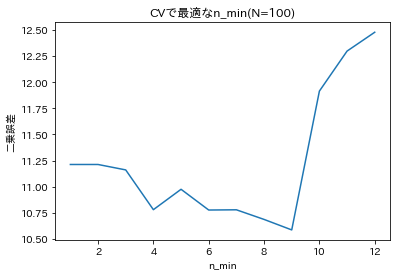

In [64]:
plt.plot(n_min_seq, out)
plt.xlabel('n_min')
plt.ylabel('二乗誤差')
plt.title('CVで最適なn_min(N=100)')